In [13]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
I1 = plt.imread("Dataset/goldengate/3.png")
I2 = plt.imread("Dataset/goldengate/4.png")

In [15]:
from skimage import filters
import cv2

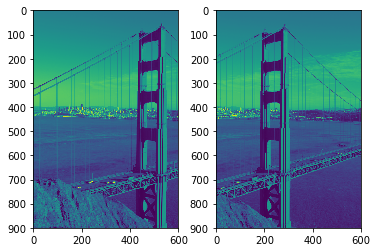

In [16]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(I1)
plt.subplot(1,2,2)
plt.imshow(I2)

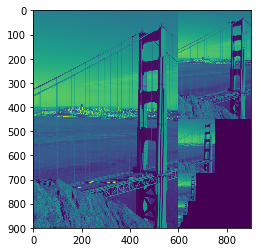

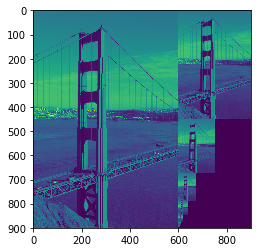

In [17]:
from skimage import data
from skimage.transform import pyramid_gaussian

#image = data.astronaut()
#rows, cols, dim = image.shape
rows, cols = I1.shape
dim = 1
pyramid1 = tuple(pyramid_gaussian(I1, downscale=2))

#composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)
composite_image = np.zeros((rows, cols + cols // 2), dtype=np.double)

#composite_image[:rows, :cols, :] = pyramid[0]
composite_image[:rows, :cols] = pyramid1[0]

i_row = 0
for p in pyramid1[1:8]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

#image = data.astronaut()
#rows, cols, dim = image.shape
rows, cols = I2.shape
dim = 1
pyramid2 = tuple(pyramid_gaussian(I2, downscale=2))

#composite_image = np.zeros((rows, cols + cols // 2, 3), dtype=np.double)
composite_image = np.zeros((rows, cols + cols // 2), dtype=np.double)

#composite_image[:rows, :cols, :] = pyramid[0]
composite_image[:rows, :cols] = pyramid2[0]

i_row = 0
for p in pyramid2[1:8]:
    n_rows, n_cols = p.shape[:2]
    composite_image[i_row:i_row + n_rows, cols:cols + n_cols] = p
    i_row += n_rows

fig, ax = plt.subplots()
ax.imshow(composite_image)
plt.show()

In [18]:
len(pyramid1)

11

In [19]:
def incrementp(I1,I2):
    I2x = filters.sobel_h(I2) 
    I2y = filters.sobel_v(I2) 
    indices = np.where(I1!=[-90000])
    coordinates = zip(indices[0], indices[1])
    xindex = np.reshape(indices[0],(I1.shape))
    yindex = np.reshape(indices[1],(I1.shape))
    #xindex = xindex/np.max(xindex)
    #yindex = yindex/np.max(yindex)
    doa11 = I2x*xindex
    doa12 = I2x*yindex
    doa13 = I2x
    doa21 = I2y*xindex
    doa22 = I2y*yindex
    doa23 = I2y
    M1 = [[np.sum(doa11*doa11),np.sum(doa11*doa12),np.sum(doa11*doa13),np.sum(doa11*doa21),np.sum(doa11*doa22),np.sum(doa11*doa23)],
          [np.sum(doa12*doa11),np.sum(doa12*doa12),np.sum(doa12*doa13),np.sum(doa12*doa21),np.sum(doa12*doa22),np.sum(doa12*doa23)],
          [np.sum(doa13*doa11),np.sum(doa13*doa12),np.sum(doa13*doa13),np.sum(doa13*doa21),np.sum(doa13*doa22),np.sum(doa13*doa23)],
          [np.sum(doa21*doa11),np.sum(doa21*doa12),np.sum(doa21*doa13),np.sum(doa21*doa21),np.sum(doa21*doa22),np.sum(doa21*doa23)],
          [np.sum(doa22*doa11),np.sum(doa22*doa12),np.sum(doa22*doa13),np.sum(doa22*doa21),np.sum(doa22*doa22),np.sum(doa22*doa23)],
          [np.sum(doa23*doa11),np.sum(doa23*doa12),np.sum(doa23*doa13),np.sum(doa23*doa21),np.sum(doa23*doa22),np.sum(doa23*doa23)]]
    M1 = np.array(M1)
    diff = I2-I1
    M2 = np.array([np.sum(doa11*diff),np.sum(doa12*diff),np.sum(doa13*diff),np.sum(doa21*diff),np.sum(doa22*diff),np.sum(doa23*diff)])
    M2 = -1*M2
    M2 = np.reshape(M2,(6,1))
    M1 = np.array(M1)
    deltap = np.matmul(np.linalg.inv(M1),M2)
    return deltap

In [20]:
p = incrementp(I1,I2)

In [21]:
p

array([[ 9.41977405e-05],
       [-5.15454711e-05],
       [-3.91610940e-02],
       [ 4.28886097e-06],
       [ 1.26106692e-04],
       [-3.56867737e-02]])

In [22]:
#https://www.learnopencv.com/image-alignment-feature-based-using-opencv-c-python/
#https://github.com/vishwa91/pyimreg
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.15
#Find transformation on img1 to reach img2; 
def alignImages(im1, im2):
    im1Gray = im1
    im2Gray = im2
    # Use grayscale images 
    # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
    # Match features.
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
    # Remove not so good matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    #cv2.imwrite("matches.jpg", imMatches)
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
    # Use homography
    height, width = im2.shape
    #im1Reg = cv2.warpPerspective(im1, h, (width, height))
    result = cv2.warpPerspective(im1, h,(im1.shape[1] + im2.shape[1], im1.shape[0]))
    result[0:im2.shape[0], 0:im2.shape[1]] = im2
    return result, h


In [23]:
I1 = I1*255
img1 = np.full((I1.shape), I1, dtype = np.uint8)
I2 = I2*255
img2 = np.full((I2.shape), I2, dtype = np.uint8)

In [24]:
imReg, h = alignImages(img1,img2)

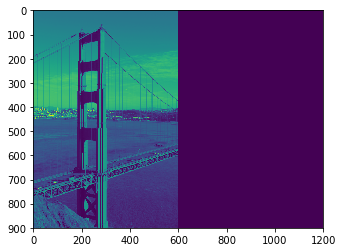

In [25]:
plt.imshow(imReg)

In [26]:
def updatep(h,p):
    h[0,0]=h[0,0]+p[0]
    h[0,1]=h[0,1]+p[1]
    h[0,2]=h[0,2]+p[2]
    h[1,0]=h[1,0]+p[3]
    h[1,1]=h[1,1]+p[4]
    h[1,2]=h[1,2]+p[5]
    return h

In [56]:
def registerim1toim2(I1,I2):
#Load image 1 and 2 and register
    I1 = I1*255
    img1 = np.full((I1.shape), I1, dtype = np.uint8)
    I2 = I2*255
    img2 = np.full((I2.shape), I2, dtype = np.uint8)
    imReg, h = alignImages(img1,img2) #get initial h
    imReg = imReg/255.0
    I2 = I2/255.0
    a = I1.shape
    imReg = cv2.resize(imReg,(a[1],a[0]))
    p = incrementp(imReg,I2) #Refine using affine lucas kanade
    h = updatep(h,p)
    height, width = I2.shape
    #imReg = imReg*255
    #imReg = np.full((imReg.shape), imReg, dtype = np.uint8)
    #imReg = cv2.warpPerspective(imReg, h, (width, height))
    result = cv2.warpPerspective(I1, h,(I1.shape[1] + I2.shape[1], I1.shape[0]))
    result[0:I2.shape[0], 0:I2.shape[1]] = I2
    result = cv2.resize(result,(a[1],a[0]))
    return result

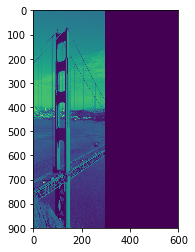

In [28]:
#Register golden gate
I3 = plt.imread("Dataset/goldengate/3.png")
I4 = plt.imread("Dataset/goldengate/4.png")
imReg2 = registerim1toim2(I3,I4)  
plt.imshow(imReg2)


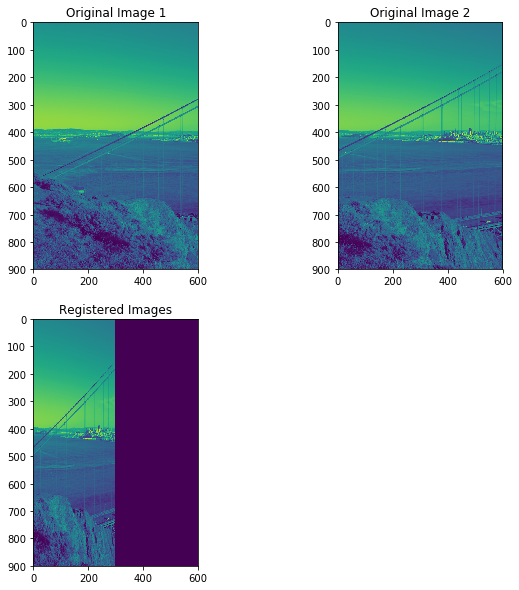

In [44]:
plt.figure(figsize=(10,10))
I1 = plt.imread("Dataset/goldengate/1.png")#Change for other pairs of images
I2 = plt.imread("Dataset/goldengate/2.png")#Change for other pairs of images
plt.subplot(2,2,1)
plt.title('Original Image 1')
plt.imshow(I1)
plt.subplot(2,2,2)
plt.title('Original Image 2')
plt.imshow(I2)
imReg = registerim1toim2(I1,I2)  
#plt.figure()
plt.subplot(2,2,3)
plt.title('Registered Images')
plt.imshow(imReg)


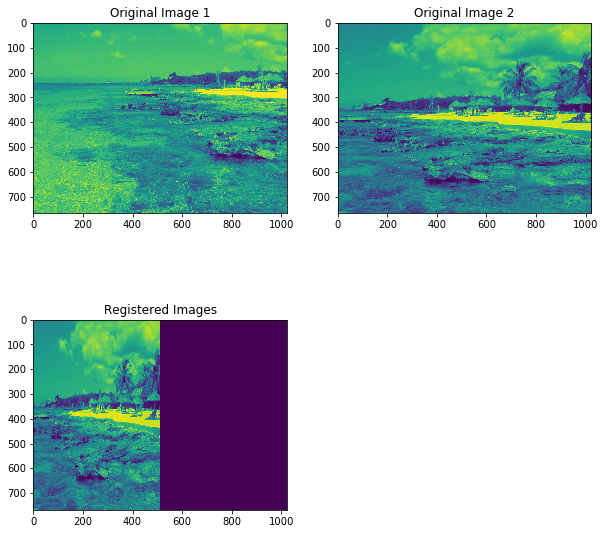

In [51]:
plt.figure(figsize=(10,10))
I1 = plt.imread("Dataset/hotel/8.png")#Change for other pairs of images
I2 = plt.imread("Dataset/hotel/7.png")#Change for other pairs of images
plt.subplot(2,2,1)
plt.title('Original Image 1')
plt.imshow(I1)
plt.subplot(2,2,2)
plt.title('Original Image 2')
plt.imshow(I2)
imReg = registerim1toim2(I1,I2)  
#plt.figure()
plt.subplot(2,2,3)
plt.title('Registered Images')
plt.imshow(imReg)


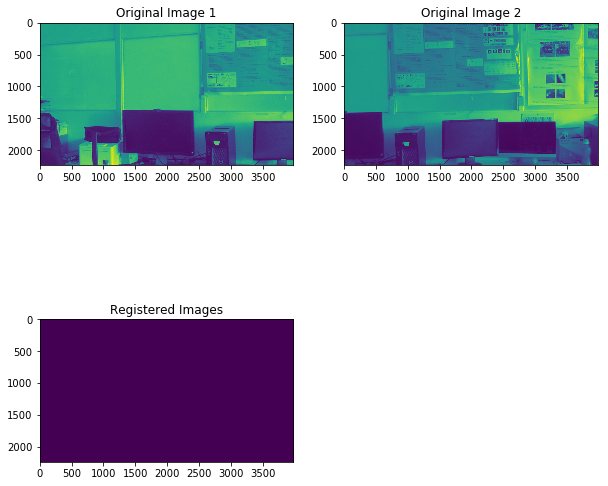

In [57]:
plt.figure(figsize=(10,10))
I1 = plt.imread("Dataset/cv-lab/3.jpg")#Change for other pairs of images
I2 = plt.imread("Dataset/cv-lab/4.jpg")#Change for other pairs of images
I1 = cv2.cvtColor(I1, cv2.COLOR_BGR2GRAY)
I2 = cv2.cvtColor(I2, cv2.COLOR_BGR2GRAY)
plt.subplot(2,2,1)
plt.title('Original Image 1')
plt.imshow(I1)
plt.subplot(2,2,2)
plt.title('Original Image 2')
plt.imshow(I2)
imReg = registerim1toim2(I1,I2)  
#plt.figure()
plt.subplot(2,2,3)
plt.title('Registered Images')
plt.imshow(imReg)


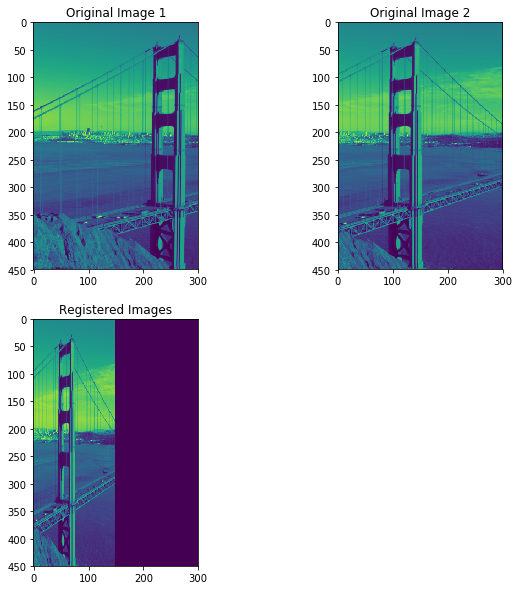

In [66]:
plt.figure(figsize=(10,10))
I1 = pyramid1[1]
I2 = pyramid2[1]
plt.subplot(2,2,1)
plt.title('Original Image 1')
plt.imshow(I1)
plt.subplot(2,2,2)
plt.title('Original Image 2')
plt.imshow(I2)
imReg = registerim1toim2(I1,I2)  
#plt.figure()
plt.subplot(2,2,3)
plt.title('Registered Images')
plt.imshow(imReg)